# Peramalan Direct multi-step 

Strategi ini, yang umumnya dikenal sebagai peramalan Direct multi-step, secara komputasi lebih mahal daripada peramalan rekursif karena memerlukan pelatihan beberapa model. Namun, dalam beberapa skenario, strategi ini menghasilkan hasil yang lebih baik. Jenis model ini dapat diperoleh dengan kelas `ForecasterAutoregDirect` dan juga dapat menyertakan satu atau beberapa variabel eksogen.

Pperamalan Direct multi-step adalah strategi peramalan deret waktu di mana model terpisah dilatih untuk memprediksi setiap langkah dalam  peramalan. Hal ini berbeda dengan peramalan multi-langkah rekursif, di mana satu model digunakan untuk membuat prediksi untuk semua langkah waktu mendatang dengan menggunakan outputnya sendiri secara rekursif sebagai input.

Peramalan multi-langkah langsung dapat lebih mahal secara komputasi daripada peramalan rekursif karena memerlukan pelatihan beberapa model. Namun, peramalan ini sering kali dapat mencapai akurasi yang lebih baik dalam skenario tertentu, terutama ketika ada pola dan ketergantungan yang kompleks dalam data yang sulit ditangkap dengan satu model.

Pendekatan ini dapat dilakukan menggunakan kelas `ForecasterAutoregDirect`, yang juga dapat menggabungkan satu atau beberapa variabel eksogen untuk meningkatkan akurasi prakiraan

<p style="text-align: center">
<img src="img/diagram-direct-multi-step-forecasting.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram peramalan direct multi-step </i></font>
</p>

Untuk melatih `ForecasterAutoregDirect` beberapa matrik  training dibuat untuk setiap model.

<p style="text-align: center">
<img src="img/diagram_skforecast_multioutput.png" style="width: 700px">
<br>
<font size="2.5"> <i>Transformasi dari deret waktu untuk melatih model peramalan direct multi-step.</i></font>
</p>

## Libraries

In [2]:
%%capture
!pip install skforecast

In [3]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


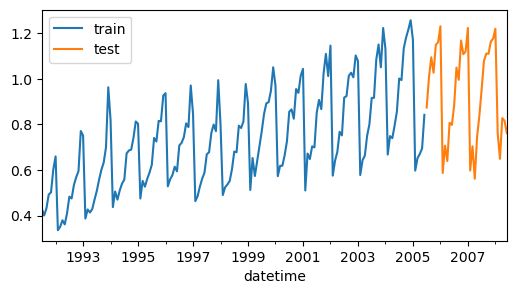

In [4]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Membuat dan melatih model

In [5]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(),
                 steps         = 36,
                 lags          = 15,
                 transformer_y = None,
                 n_jobs        = 'auto'
             )

forecaster.fit(y=data_train)


## Prediksi

Saat memprediksi, nilai `step` harus kurang dari atau sama dengan nilai step yang ditetapkan saat menginisialisasi peramalan. Dimulai dari 1.

+ Jika `int`, hanya step dalam rentang 1 hingga int yang diprediksi.

+ Jika `list` dari `int`, hanya langkah yang terdapat dalam daftar yang diprediksi.

+ Jika `None`, sebanyak langkah yang diprediksi seperti yang ditetapkan saat inisialisasi.

In [11]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=[1,5])
display(predictions)

2005-07-01    0.952051
2005-11-01    1.179922
Name: pred, dtype: float64

In [14]:
# Predict all steps defined in the initialization.
predictions = forecaster.predict()
display(predictions.head(3))

2005-07-01    0.952051
2005-08-01    1.004145
2005-09-01    1.114590
Name: pred, dtype: float64

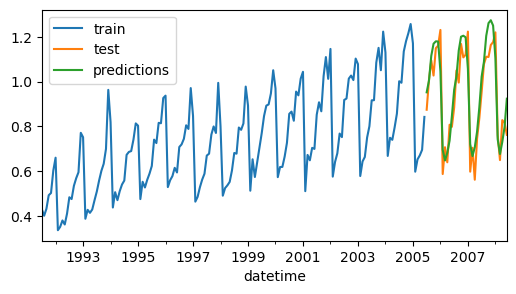

In [15]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [16]:
# Prediction error
# ==============================================================================
predictions = forecaster.predict(steps=36)

error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
            
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008419597278831965


## Fitur  Penting

Karena `ForecasterAutoregDirect` cocok dengan satu model per step, maka perlu untuk menentukan dari model mana fitur penting yang diambil.

In [17]:
forecaster.get_feature_importances(step=1)

,feature,importance
11,lag_12,0.551652
10,lag_11,0.154030
0,lag_1,0.139299
12,lag_13,0.057513
1,lag_2,0.051089
2,lag_3,0.044192
9,lag_10,0.020511
8,lag_9,0.011918
7,lag_8,-0.012591
5,lag_6,-0.013233


## Mengektrak matrik training

Dua tahap yang diperlukan untuk mengekstrak matriks pelatihan matrik. Yang pertama untuk membuat seluruh matriks pelatihan dan yang kedua untuk membuat subset data yang diperlukan untuk setiap model (step).

In [18]:
# Create the whole train matrix
X, y = forecaster.create_train_X_y(data_train)

# Extract X and y to train the model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step          = 3,
               X_train       = X,
               y_train       = y,
               remove_suffix = False
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1993-01-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1993-02-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1993-03-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543


In [19]:
y_1.shape

(118,)

In [20]:
y_1.head(40)

datetime
1992-12-01    0.771258
1993-01-01    0.751503
1993-02-01    0.387554
1993-03-01    0.427283
1993-04-01    0.413890
1993-05-01    0.428859
1993-06-01    0.470126
1993-07-01    0.509210
1993-08-01    0.558443
1993-09-01    0.601514
1993-10-01    0.632947
1993-11-01    0.699605
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
1994-05-01    0.510696
1994-06-01    0.540514
1994-07-01    0.558119
1994-08-01    0.672852
1994-09-01    0.685897
1994-10-01    0.689692
1994-11-01    0.741304
1994-12-01    0.813308
1995-01-01    0.803113
1995-02-01    0.475258
1995-03-01    0.552572
1995-04-01    0.527108
1995-05-01    0.561250
1995-06-01    0.588978
1995-07-01    0.623134
1995-08-01    0.740837
1995-09-01    0.725372
1995-10-01    0.815803
1995-11-01    0.814009
1995-12-01    0.926653
1996-01-01    0.937276
1996-02-01    0.528762
1996-03-01    0.559340
Freq: MS, Name: y_step_3, dtype: float64

## Mengekstrak matriks prediksi

Skforecast menyediakan metode `create_predict_X` untuk menghasilkan matriks yang digunakan peramalan untuk membuat prediksi. Metode ini dapat digunakan untuk mendapatkan wawasan tentang manipulasi data spesifik yang terjadi selama proses prediksi.

In [21]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=5)
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
2005-07-01,0.842263,0.695248,0.670505,0.65259,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986
2005-08-01,0.842263,0.695248,0.670505,0.65259,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986
2005-09-01,0.842263,0.695248,0.670505,0.65259,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986
2005-10-01,0.842263,0.695248,0.670505,0.65259,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986
2005-11-01,0.842263,0.695248,0.670505,0.65259,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986


# Persiapan Multi Output XGBoost Regressor

https://github.com/KasperGroesLudvigsen/xgboost_time_series/blob/main/train_test_xgboost.ipynb

https://www.forecastclub.blog/2024/08/6-methods-for-multi-step-forecasting.html

In [23]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate a synthetic univariate time series dataset
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

# Prepare data for supervised learning



In [24]:
type(series)

numpy.ndarray

In [25]:
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i : i + n_steps_in])
        y.append(data[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 3
X, y = create_dataset(df['series'].values, n_steps_in, n_steps_out)

# Chronological split of data into train and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Initialize an XGBRegressor model wrapped in a MultiOutputRegressor
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model = MultiOutputRegressor(base_model)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make multi-step predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Visualize the actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.show()

NameError: name 'df' is not defined